In [1]:
#Import Relevant Libraries and read the json file. 

import numpy as np
import pandas as pd 
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

transaction = "transaction-data-adhoc-analysis.json"

df = pd.read_json(transaction)

In [2]:
# PRELIMINARY TABLE: All Transaction Items and their Corresponding Prices
unique_df = df[df['transaction_items'].str.contains('x1') & ~df['transaction_items'].str.contains(';')].copy() #Copy finds  "x1" and NOT ":" for single item entries individual.
unique_df['transaction_items'] = unique_df['transaction_items'].str[:-5] #remove "x#"

brand_and_product = unique_df['transaction_items'].unique() 
brand_and_product_df = pd.DataFrame(brand_and_product,columns=['Brand & Product']) #new brand_and_product dataframe based on unique transaction items
isp = unique_df['transaction_value'].unique()
isp_df = pd.DataFrame(isp,columns = ['Individual Sale Price']) #new isp dataframe based on individual sale price.
product_isp_df = pd.concat([brand_and_product_df, isp_df], axis =1) #merged brand_and_prdouct and isp dataframes based on rows.

#Split the Brand and Product for cleaner table, appended Individual Sale Price to the end of the table 
product_isp_df[['Brand','Product']] = product_isp_df['Brand & Product'].str.split(',', expand = True) 
product_isp_df = product_isp_df.drop(['Brand & Product'], axis = 1)
cols = list(product_isp_df.columns)
cols.append(cols.pop(cols.index('Individual Sale Price')))
product_isp_df = product_isp_df.sort_values(['Brand','Product']) #Alphabetically sort by Brand
product_isp_df = product_isp_df[cols]
product_isp_df

,Brand,Product,Individual Sale Price
1,Candy City,Gummy Worms,150
4,Candy City,Orange Beans,199
2,Exotic Extras,Beef Chicharon,1299
3,Exotic Extras,Kimchi and Seaweed,799
5,HealthyKid 3+,Gummy Vitamins,1500
6,HealthyKid 3+,Nutrional Milk,1990
0,HealthyKid 3+,Yummy Vegetables,500


In [3]:
# TABLE PROCESSING

# 1. Add transaction_id to preserve the grouping of respective transactions
transactions_list = df['transaction_items'].tolist()
df['transaction_id'] = np.arange(1,len(transactions_list) + 1)

# 2. Reduce granularity of table via split on ';'and explode entries
df['transaction_items'] = df['transaction_items'].str.split(';')
df = df.explode('transaction_items').reset_index(drop=True)
df[['brand','product','Amount']] = df['transaction_items'].str.split(',', expand=True)

# 3. Modify address and transaction_date to concise output (i.e. Area codes and Months)
df['address'] = df['address'].str[-8:]
df['transaction_date'] = df['transaction_date'].str[:-3]

# 4. Merged product_isp_df with df to include individual sales price of products per entry, also found sum price of products per entry
df = df.merge(product_isp_df,how = 'left',left_on = 'product', right_on = 'Product')
df = df.rename(columns = {'Individual Sale Price':'individual_sale_price'})
df['amount_purchased'] = df['Amount'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
df['sum_price'] = df['amount_purchased'] * df['individual_sale_price'] 

# 5. Rearranged columns
df = df[['transaction_date','transaction_id','username','address','transaction_value','brand','product','amount_purchased','individual_sale_price','sum_price']]
df

,transaction_date,transaction_id,username,address,transaction_value,brand,product,amount_purchased,individual_sale_price,sum_price
0,2022/01,1,veronicawells,AE 00917,5196,Exotic Extras,Beef Chicharon,4,1299,5196
1,2022/01,2,cgilbert,AP 48794,12056,Exotic Extras,Beef Chicharon,3,1299,3897
2,2022/01,2,cgilbert,AP 48794,12056,HealthyKid 3+,Nutrional Milk,4,1990,7960
3,2022/01,2,cgilbert,AP 48794,12056,Candy City,Orange Beans,1,199,199
4,2022/01,3,cgilbert,AP 48794,5500,HealthyKid 3+,Gummy Vitamins,3,1500,4500
...,...,...,...,...,...,...,...,...,...,...
166114,2022/06,83035,llowe,SD 27217,4280,HealthyKid 3+,Nutrional Milk,2,1990,3980
166115,2022/06,83035,llowe,SD 27217,4280,Candy City,Gummy Worms,2,150,300
166116,2022/06,83036,cmcdowell,AE 08973,2639,HealthyKid 3+,Nutrional Milk,1,1990,1990
166117,2022/06,83036,cmcdowell,AE 08973,2639,Candy City,Gummy Worms,3,150,450


In [4]:
# PIVOT TABLE 1: Count of each Product Sold per Month
total_count_pivot_table = pd.pivot_table(df, values = "amount_purchased", index = ["brand","product"], columns = "transaction_date",aggfunc= 'sum')
total_count_pivot_table = total_count_pivot_table.rename_axis("",axis=1)
total_count_pivot_table.columns = ['2022/01 Count','2022/02 Count','2022/03 Count','2022/04 Count','2022/05 Count','2022/06 Count']
total_count_pivot_table.index.rename(["Brand","Product"], inplace=True)

total_count_value = total_count_pivot_table.loc[:, total_count_pivot_table.columns]
total_count_pivot_table['Total Product Count'] = total_count_value.sum(axis=1)
total_count_pivot_table = total_count_pivot_table.reset_index()
total_count_pivot_table

,Brand,Product,2022/01 Count,2022/02 Count,2022/03 Count,2022/04 Count,2022/05 Count,2022/06 Count,Total Product Count
0,Candy City,Gummy Worms,9559,9996,9986,10043,9801,9934,59319
1,Candy City,Orange Beans,9774,10037,9611,9914,9964,10106,59406
2,Exotic Extras,Beef Chicharon,9665,10001,9816,9890,10028,9902,59302
3,Exotic Extras,Kimchi and Seaweed,9676,9949,9967,9921,9773,10104,59390
4,HealthyKid 3+,Gummy Vitamins,9681,9980,10145,9842,9948,9980,59576
5,HealthyKid 3+,Nutrional Milk,9727,9691,9876,9786,9881,9767,58728
6,HealthyKid 3+,Yummy Vegetables,9959,10256,9896,9861,9735,9722,59429


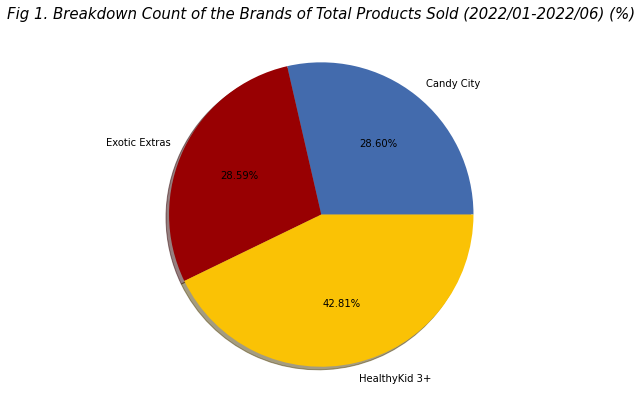

In [5]:
# ADDITIONAL VISUAL #1: PIE CHART regarding the Breakdown Count of the BRANDS of Total Products Sold
plt.figure(figsize=(14,7))
plt.title('Fig 1. Breakdown Count of the Brands of Total Products Sold (2022/01-2022/06) (%)',fontsize = 15, fontstyle = 'italic')
total_count = list(total_count_pivot_table['Total Product Count'])
brand_count = list(total_count_pivot_table['Brand'])
colours = ['xkcd:french blue','xkcd:blood red','xkcd:goldenrod']

brandDict = {}
for i, v in zip(brand_count, total_count):
    if not i in brandDict:
        brandDict.update({i: v})
    else:
        brandDict[i] += v
        
plt.pie(brandDict.values(), labels = brandDict.keys(), colors = colours, autopct = '%.2f%%',shadow = True)
plt.savefig('1_pie_brand_count.jpg', bbox_inches='tight')

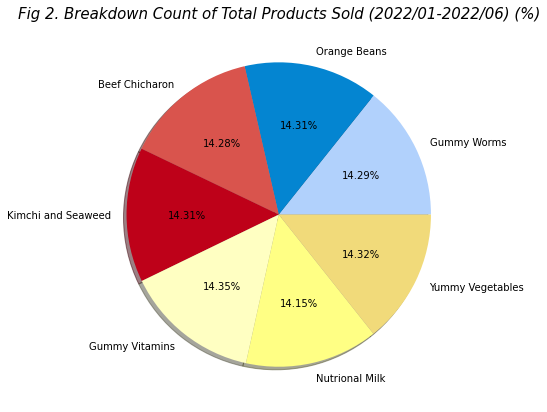

In [6]:
# ADDITIONAL VISUAL #2: PIE CHART regarding the Breakdown Count of the Total Products Sold
plt.figure(figsize=(14,7))
plt.title('Fig 2. Breakdown Count of Total Products Sold (2022/01-2022/06) (%)',fontsize = 15, fontstyle = 'italic')
colours = ['xkcd:powder blue','xkcd:cerulean','xkcd:pale red','xkcd:scarlet','xkcd:cream','xkcd:pale yellow','xkcd:sandy']
plt_count = plt.pie(data=total_count_pivot_table, x=total_count_pivot_table['Total Product Count'], labels = 'Product',  colors = colours, autopct='%.2f%%',shadow = True)
plt.savefig('2_pie_product_count.jpg', bbox_inches='tight')

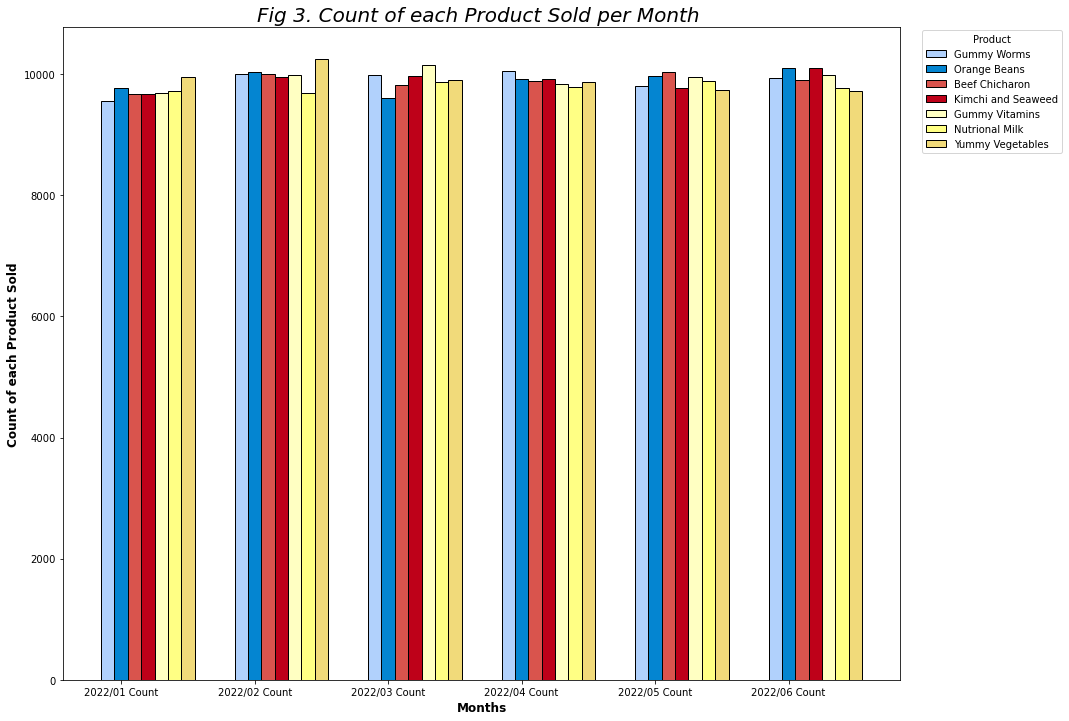

In [7]:
# ADDITIONAL VISUAL #3: BAR GRAPH regarding the Count per Product Sold per Month 
# Set width of bar and variables
barWidth = 0.10
fig = plt.subplots(figsize =(15, 12))
Gummy_Worms_Count = total_count_pivot_table.iloc[0:1,2:8].values.tolist()[0]
Orange_Beans_Count = total_count_pivot_table.iloc[1:2,2:8].values.tolist()[0]
Beef_Chicharon_Count = total_count_pivot_table.iloc[2:3,2:8].values.tolist()[0]
Kimchi_and_Seaweed_Count = total_count_pivot_table.iloc[3:4,2:8].values.tolist()[0]
Gummy_Vitamins_Count = total_count_pivot_table.iloc[4:5,2:8].values.tolist()[0]
Nutrional_Milk_Count = total_count_pivot_table.iloc[5:6,2:8].values.tolist()[0]
Yummy_Vegetables_Count = total_count_pivot_table.iloc[6:7,2:8].values.tolist()[0]

# Set position of bar on X axis
count_br1 = np.arange(len(Gummy_Worms_Count))
count_br2 = [x + barWidth for x in count_br1]
count_br3 = [x + barWidth for x in count_br2]
count_br4 = [x + barWidth for x in count_br3]
count_br5 = [x + barWidth for x in count_br4]
count_br6 = [x + barWidth for x in count_br5]
count_br7 = [x + barWidth for x in count_br6]

# Plot count of products
plt.bar(count_br1, Gummy_Worms_Count, color = 'xkcd:powder blue', width = barWidth,
        edgecolor ='black', label ='Gummy Worms')
plt.bar(count_br2, Orange_Beans_Count, color ='xkcd:cerulean', width = barWidth,
        edgecolor ='black', label ='Orange Beans')
plt.bar(count_br3, Beef_Chicharon_Count, color ='xkcd:pale red', width = barWidth,
        edgecolor ='black', label ='Beef Chicharon')
plt.bar(count_br4, Kimchi_and_Seaweed_Count, color ='xkcd:scarlet', width = barWidth,
        edgecolor ='black', label ='Kimchi and Seaweed')
plt.bar(count_br5, Gummy_Vitamins_Count, color ='xkcd:cream', width = barWidth,
        edgecolor ='black', label ='Gummy Vitamins')
plt.bar(count_br6, Nutrional_Milk_Count, color ='xkcd:pale yellow', width = barWidth,
        edgecolor ='black', label ='Nutrional Milk')
plt.bar(count_br7, Yummy_Vegetables_Count, color ='xkcd:sandy', width = barWidth,
        edgecolor ='black', label ='Yummy Vegetables')

# Set title, labels, and legend
plt.title('Fig 3. Count of each Product Sold per Month ', fontstyle = 'italic', fontsize = 20)
plt.xlabel('Months', fontweight = 'bold', fontsize = 12)
plt.ylabel('Count of each Product Sold', fontweight = 'bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(count_br1))], list(total_count_pivot_table.iloc[0:1,2:8]))
plt.legend(loc=4, title="Product",bbox_to_anchor = (1.20, 0.8))
plt.savefig('3_bar_product_count.jpg', bbox_inches='tight')

In [8]:
# PIVOT TABLE 2: Total Sales Value per Product per Month
total_sales_pivot_table = pd.pivot_table(df, values = "amount_purchased", index = ["brand","product"], columns = "transaction_date",aggfunc= 'sum')
total_sales_pivot_table.index.rename(["Brand","Product"], inplace=True)
total_sales_pivot_table.insert(0,'Individual Sale Price',pd.array(product_isp_df["Individual Sale Price"]))
total_sales_pivot_table = total_sales_pivot_table.rename_axis("",axis=1)

# Multiplied reference individual sale price by item count for the month (price * indiv. quantity)
total_sales_pivot_table['2022/01 Sales'] = total_sales_pivot_table['2022/01'] * total_sales_pivot_table['Individual Sale Price']
total_sales_pivot_table['2022/02 Sales'] = total_sales_pivot_table['2022/02'] * total_sales_pivot_table['Individual Sale Price']
total_sales_pivot_table['2022/03 Sales'] = total_sales_pivot_table['2022/03'] * total_sales_pivot_table['Individual Sale Price']
total_sales_pivot_table['2022/04 Sales'] = total_sales_pivot_table['2022/04'] * total_sales_pivot_table['Individual Sale Price']
total_sales_pivot_table['2022/05 Sales'] = total_sales_pivot_table['2022/05'] * total_sales_pivot_table['Individual Sale Price']
total_sales_pivot_table['2022/06 Sales'] = total_sales_pivot_table['2022/06'] * total_sales_pivot_table['Individual Sale Price']
total_sales_pivot_table = total_sales_pivot_table.drop(total_sales_pivot_table.iloc[:, 1:7], axis=1) #dropped all old 'count' columns. 

# Summary Information
total_sales_value = total_sales_pivot_table.loc[:, total_sales_pivot_table.columns!='Individual Sale Price']
total_sales_pivot_table['Total Product Sales Value'] = total_sales_value.sum(axis=1) # Total Sales Value for each Product (row-wise sum)
total_sales_pivot_table = total_sales_pivot_table.reset_index()
total_sales_pivot_table.loc[len(total_sales_pivot_table.index)] = total_sales_value.sum() # Total Sales Value for every Month (column-wise sum)
total_sales_pivot_table = total_sales_pivot_table.rename(index={7:'Total Monthly Sales Value'}).fillna('--') #did not include Individual Sale Price, so just renamed final row Total Sale Value per month and left Nan as "--"
total_sales_pivot_table

,Brand,Product,Individual Sale Price,2022/01 Sales,2022/02 Sales,2022/03 Sales,2022/04 Sales,2022/05 Sales,2022/06 Sales,Total Product Sales Value
0,Candy City,Gummy Worms,150.0,1433850.0,1499400.0,1497900.0,1506450.0,1470150.0,1490100.0,8897850.0
1,Candy City,Orange Beans,199.0,1945026.0,1997363.0,1912589.0,1972886.0,1982836.0,2011094.0,11821794.0
2,Exotic Extras,Beef Chicharon,1299.0,12554835.0,12991299.0,12750984.0,12847110.0,13026372.0,12862698.0,77033298.0
3,Exotic Extras,Kimchi and Seaweed,799.0,7731124.0,7949251.0,7963633.0,7926879.0,7808627.0,8073096.0,47452610.0
4,HealthyKid 3+,Gummy Vitamins,1500.0,14521500.0,14970000.0,15217500.0,14763000.0,14922000.0,14970000.0,89364000.0
5,HealthyKid 3+,Nutrional Milk,1990.0,19356730.0,19285090.0,19653240.0,19474140.0,19663190.0,19436330.0,116868720.0
6,HealthyKid 3+,Yummy Vegetables,500.0,4979500.0,5128000.0,4948000.0,4930500.0,4867500.0,4861000.0,29714500.0
Total Monthly Sales Value,--,--,--,62522565.0,63820403.0,63943846.0,63420965.0,63740675.0,63704318.0,--


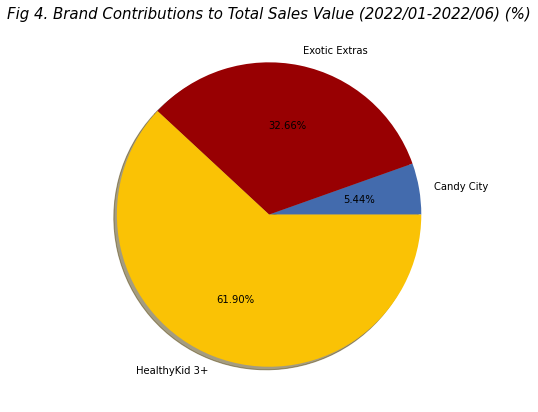

In [9]:
# ADDITIONAL VISUAL #4: PIE CHART regarding BRAND Contributions to Total Sales Value (2022/01 to 2022/06)
plt.figure(figsize=(14,7))
plt.title('Fig 4. Brand Contributions to Total Sales Value (2022/01-2022/06) (%)',fontsize = 15, fontstyle = 'italic')
total_sales = list(total_sales_pivot_table.iloc[0:7,9])
brand_sales = list(total_sales_pivot_table.iloc[0:7,0])
colours = ['xkcd:french blue','xkcd:blood red','xkcd:goldenrod']

brandDict = {}
for i, v in zip(brand_sales, total_sales):
    if not i in brandDict:
        brandDict.update({i: v})
    else:
        brandDict[i] += v
        
plt.pie(brandDict.values(), labels=brandDict.keys(), colors = colours, autopct='%.2f%%',shadow = True)
plt.savefig('4_pie_brand_sales_contributions.jpg', bbox_inches='tight')

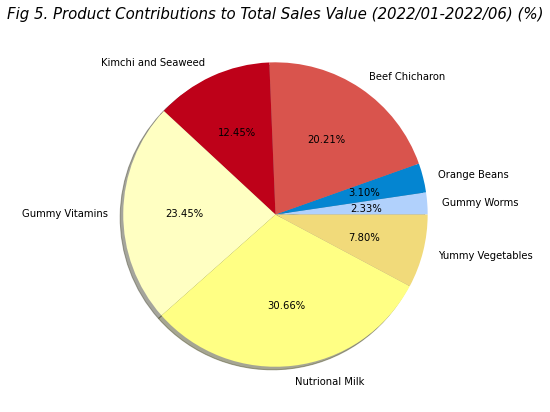

In [10]:
# ADDITIONAL VISUAL #5: PIE CHART regarding Product Contributions to Total Sales Value (2022/01 to 2022/06)
plt.figure(figsize=(14,7))
plt.title('Fig 5. Product Contributions to Total Sales Value (2022/01-2022/06) (%)',fontsize = 15, fontstyle = 'italic')
colours = ['xkcd:powder blue','xkcd:cerulean','xkcd:pale red','xkcd:scarlet','xkcd:cream','xkcd:pale yellow','xkcd:sandy']
plt_count = plt.pie(data=total_sales_pivot_table, x=total_sales_pivot_table.iloc[0:7,9], labels = total_sales_pivot_table.iloc[0:7,1],  colors = colours, autopct='%.2f%%',shadow = True)
plt.savefig('5_pie_product_sales_contribtions.jpg', bbox_inches='tight')

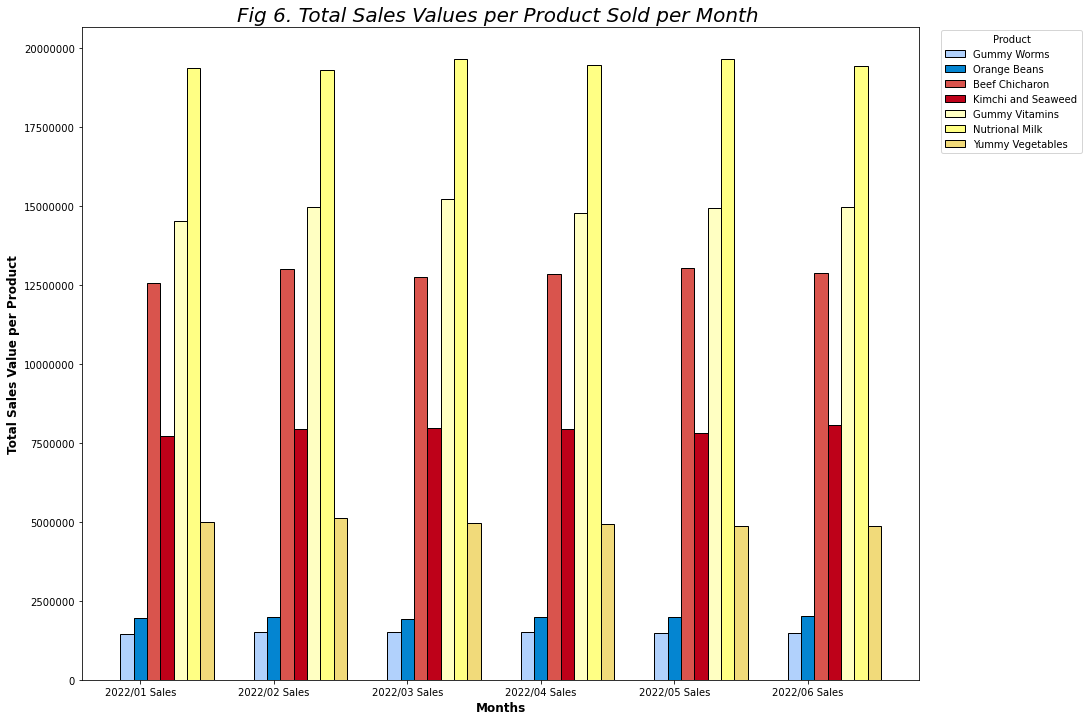

In [11]:
# ADDITIONAL VISUAL #6: Bar Graph for the Value of every Product Sold per Month 
# Set width of bar and variables
barWidth = 0.10
fig = plt.subplots(figsize =(15, 12))
Gummy_Worms_Sales = total_sales_pivot_table.iloc[0:1,3:9].values.tolist()[0]
Orange_Beans_Sales = total_sales_pivot_table.iloc[1:2,3:9].values.tolist()[0]
Beef_Chicharon_Sales = total_sales_pivot_table.iloc[2:3,3:9].values.tolist()[0]
Kimchi_and_Seaweed_Sales = total_sales_pivot_table.iloc[3:4,3:9].values.tolist()[0]
Gummy_Vitamins_Sales = total_sales_pivot_table.iloc[4:5,3:9].values.tolist()[0]
Nutrional_Milk_Sales = total_sales_pivot_table.iloc[5:6,3:9].values.tolist()[0]
Yummy_Vegetables_Sales = total_sales_pivot_table.iloc[6:7,3:9].values.tolist()[0]

# Set position of bar on X axis
sales_br1 = np.arange(len(Gummy_Worms_Count))
sales_br2 = [x + barWidth for x in sales_br1]
sales_br3 = [x + barWidth for x in sales_br2]
sales_br4 = [x + barWidth for x in sales_br3]
sales_br5 = [x + barWidth for x in sales_br4]
sales_br6 = [x + barWidth for x in sales_br5]
sales_br7 = [x + barWidth for x in sales_br6]

# Plot total sales values of products
plt.bar(sales_br1, Gummy_Worms_Sales, color = 'xkcd:powder blue', width = barWidth,
        edgecolor ='black', label ='Gummy Worms')
plt.bar(sales_br2, Orange_Beans_Sales, color ='xkcd:cerulean', width = barWidth,
        edgecolor ='black', label ='Orange Beans')
plt.bar(sales_br3, Beef_Chicharon_Sales, color ='xkcd:pale red', width = barWidth,
        edgecolor ='black', label ='Beef Chicharon')
plt.bar(sales_br4, Kimchi_and_Seaweed_Sales, color ='xkcd:scarlet', width = barWidth,
        edgecolor ='black', label ='Kimchi and Seaweed')
plt.bar(sales_br5, Gummy_Vitamins_Sales, color ='xkcd:cream', width = barWidth,
        edgecolor ='black', label ='Gummy Vitamins')
plt.bar(sales_br6, Nutrional_Milk_Sales, color ='xkcd:pale yellow', width = barWidth,
        edgecolor ='black', label ='Nutrional Milk')
plt.bar(sales_br7, Yummy_Vegetables_Sales, color ='xkcd:sandy', width = barWidth,
        edgecolor ='black', label ='Yummy Vegetables')

# Set title, labels, and legend
plt.title('Fig 6. Total Sales Values per Product Sold per Month ', fontstyle = 'italic', fontsize = 20)
plt.xlabel('Months', fontweight = 'bold', fontsize = 12)
plt.ylabel('Total Sales Value per Product', fontweight = 'bold', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(sales_br1))], list(total_sales_pivot_table.iloc[0:1,3:9]))
plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc=4, title="Product",bbox_to_anchor = (1.20, 0.8))
plt.savefig('6_bar_product_sales.jpg', bbox_inches='tight')

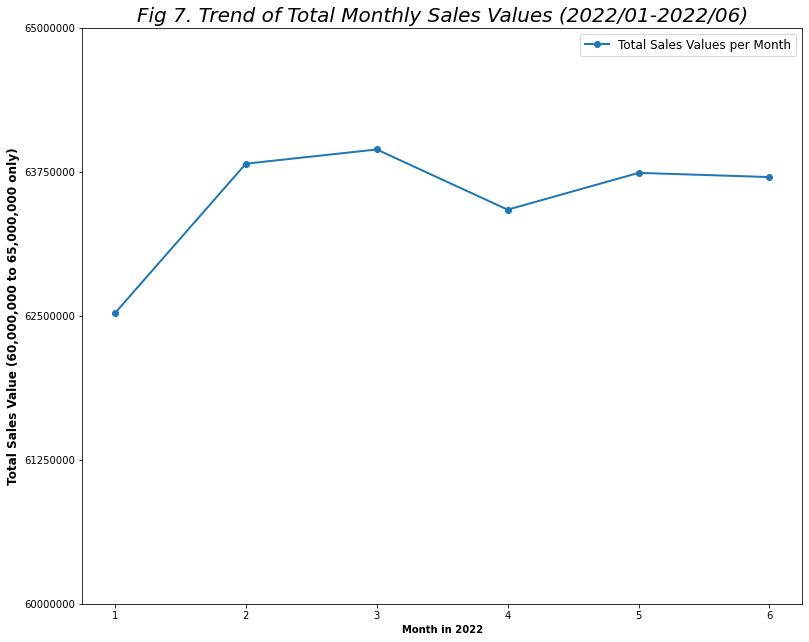

In [12]:
# ADDITIONAL VISUAL #7: Trendline of Total Monthly Sales
x_month_number = pd.factorize(df['transaction_date'].unique())[0] + 1
x = x_month_number
y = list(total_sales_value.sum())

# Set title, labels, and legend
fig = plt.figure(figsize = (10,8))
ax = fig.add_axes([0,0,1,1])
ax.plot(x,y,label="Total Sales Values per Month",lw = 2.0 ,marker="o")
ax.legend(fontsize = '12')
ax.set_title('Fig 7. Trend of Total Monthly Sales Values (2022/01-2022/06)',fontsize = 20, fontstyle = 'italic')
ax.set_xlabel('Month in 2022', fontsize = 10,fontweight='bold')
ax.set_ylabel('Total Sales Value (60,000,000 to 65,000,000 only)', fontsize = 12, fontweight='bold')
ax.set_yticks(np.arange(60_000_000, 66_250_000, 1_250_000))
plt.ticklabel_format(style = 'plain')
plt.savefig('7_total_monthly_sales.jpg', bbox_inches='tight')